In [ ]:
from datetime import datetime, timedelta,date
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import sklearn
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import warnings
warnings.filterwarnings("ignore")

# uplifitng

### 데이터 변수 설명
* recency : 마지막 구매 후 개월
* history: 과거 구매의 $value
* used_discount: 할인 사용 여부
* used_bogo: 재구매 했는지 여부
* zip_code: Suburban/Urban/Rural과 같은 우편번호 클래스
* is_referral: 추천 채널에서 고객을 획득했는지 여부를 나타냅니다.
* channel: 고객이 사용하는 채널, Phone/Web/Multichannel
* offer: 고객에게 전송된 제안, Discount/But One Get One(원플러스원)/No Offer
* conversation : (1-구매 , 0-X)

### Content

This dataset show customer's brief information,
historical use of discount or BOGO(Buy One Get One) promotion,
offer has been made, and the conversion result(buy or not).
The conversion average value = $25

----
데이터 설명에 따르면 discount 나 bogo offer를 받은 고객들은 Treatment(타겟군) 이고 나머지는 통제집단으로 볼 수 있겠다.


In [ ]:
# !kaggle datasets download -d davinwijaya/customer-retention
!unzip -o /content/customer-retention.zip -d /content

Archive:  /content/customer-retention.zip
  inflating: /content/data.csv       


In [ ]:
df= pd.read_csv('/content/uplift.csv')

In [ ]:
df

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0
...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,Urban,0,Web,Discount,0
63996,5,38.91,0,1,Urban,1,Phone,Discount,0
63997,6,29.99,1,0,Urban,1,Phone,Discount,0
63998,1,552.94,1,0,Surburban,1,Multichannel,Buy One Get One,0


# 데이터탐색

In [ ]:
df.info()

In [ ]:
# 범주형 변수 확인
df.describe(include = np.object)

,zip_code,channel,offer
count,64000,64000,64000
unique,3,3,3
top,Surburban,Web,Buy One Get One
freq,28776,28217,21387


In [ ]:
# 명목형 변수 값들 count /  데이터설명에 명시된 것 말고 이외의 값이 있나 확인해보자
zip_count = df['zip_code'].value_counts()
channel_count = df['channel'].value_counts()
offer_count = df['offer'].value_counts()

print(zip_count)
print(channel_count)
print(offer_count)



Surburban    28776
Urban        25661
Rural         9563
Name: zip_code, dtype: int64
Web             28217
Phone           28021
Multichannel     7762
Name: channel, dtype: int64
Buy One Get One    21387
Discount           21307
No Offer           21306
Name: offer, dtype: int64


In [ ]:
# 편의상 conversion 을 target 으로
# offer 를 treatment로 바꿔주자.

df = df.rename(columns={'conversion': 'target','offer':'treatment'})
df.treatment = df.treatment.map({'No Offer': 0, 'Buy One Get One': -1, 'Discount': 1}) # 0 인경우 control, -1,1 인경우 Treatment


* treatment(-1) = BOGO 원플러스원 광고를 받은 실험군
* treatment(1) = 할인 광고를 받은 실험군
* treatment(0) = 대조군



In [ ]:
df['treatment'].value_counts()

-1    21387
 1    21307
 0    21306
Name: treatment, dtype: int64

In [ ]:
# 범주형 변수 one hot encoding
df_model = pd.get_dummies(df)


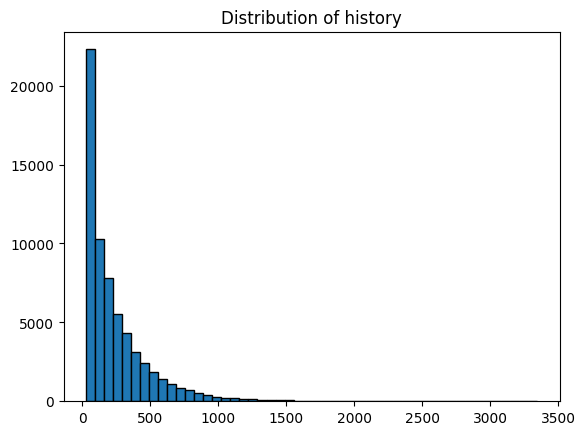

In [ ]:
# recency  history
# 히스토리의 경우 어느정도 이상치값이 있다.
import matplotlib.pyplot as plt

plt.hist(df['history'], bins=50, edgecolor='black')  # 20개의 구간으로 나누어 히스토그램 그리기
plt.title('Distribution of history')
plt.show()

In [ ]:
# target 변수
df_model_bogo = df_model.copy().loc[df_model.treatment <=0].reset_index(drop=True) # 원플원 광고를 받은 실험군과 대조군 DATA
df_model_discount = df_model.copy().loc[df_model.treatment >=0].reset_index(drop=True) # 할인 광고를 받은 실험군과 대조군 DATA

In [ ]:
df_model_bogo['treatment'] = df_model_bogo['treatment'].replace(-1, 1)

In [ ]:
df_model['treatment'] = df_model['treatment'].replace(-1,1)

## 2. Approaches with two models

The two-model approach can be found in almost any uplift modeling work and is often used as a baseline. However, using two models can lead to some unpleasant consequences: if you use fundamentally different models for training, or if the nature of the test and control group data is very different, then the scores returned by the models will not be comparable. As a result, the calculation of the uplift will not be completely correct. To avoid this effect, you need to calibrate the models so that their scores can be interpolated as probabilities. The calibration of model probabilities is described perfectly in [scikit-learn documentation](https://scikit-learn.org/stable/modules/calibration.html).

### 2.1 Two independent models

The main idea is to estimate the conditional probabilities of the treatment and control groups separately.

1. Train the first model using the treatment set.
2. Train the second model using the control set.
3. Inference: subtract the control model scores from the treatment model scores.

<p align= "center">
  <img src="https://raw.githubusercontent.com/maks-sh/scikit-uplift/master/docs/_static/images/TwoModels_vanila.png" alt="Two Models vanila"/>
</p>

In [ ]:
train, test  = train_test_split(df_model, test_size=0.2, random_state=42, stratify = df_model['treatment'])

# 주어진 피처 리스트
features = ['recency',	'history',	'used_discount',	'used_bogo',	'is_referral'	,	'zip_code_Rural',	'zip_code_Surburban',	'zip_code_Urban',	'channel_Multichannel',	'channel_Phone'	,'channel_Web']

# 피처 및 타겟을 설정하고 데이터를 분할
X = train[features]  # train 데이터프레임을 사용하여 피처 추출
y = train['target']
treatment = train['treatment']

# 데이터 분할
X_train, X_val, y_train, y_val, treat_train, treat_val = train_test_split(
    X, y, treatment, test_size=0.2, random_state=42
)

[LightGBM] [Info] Number of positive: 1450, number of negative: 12249
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 13699, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.105847 -> initscore=-2.133881
[LightGBM] [Info] Start training from score -2.133881
[LightGBM] [Info] Number of positive: 4539, number of negative: 22722
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 27261, number of used features: 11
[LightGBM] [Info

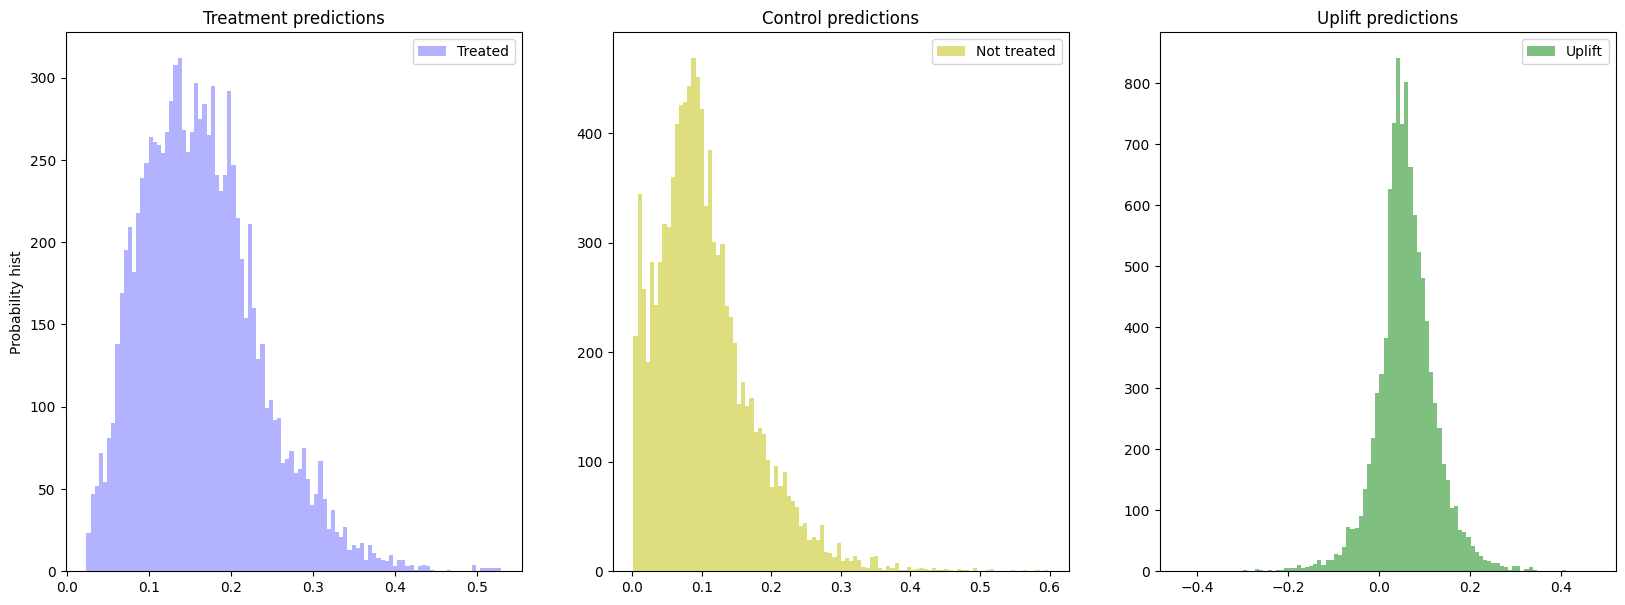

In [ ]:
models_results = {
    'approach': [],
    'uplift@30%': []
}

lgb_params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'binary_logloss'
}

# TwoModels 모델 설정
tm = TwoModels(
    estimator_trmnt=lgb.LGBMClassifier(**lgb_params),
    estimator_ctrl=lgb.LGBMClassifier(**lgb_params),
    method='vanilla'
)

# 3. 모델 학습
tm = tm.fit(
    X_train, y_train, treat_train
)

# 4. 업리프팅 예측
uplift_tm = tm.predict(X_val)

tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.3)
models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

# 5. 업리프팅 측정
plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [ ]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%
0,TwoModels,0.073687


In [ ]:
df_uplift = pd.DataFrame({'uplift_score': np.array(uplift_tm)})
df_uplift

,uplift_score
0,0.031237
1,0.001270
2,-0.054862
3,0.072842
4,0.084649
...,...
6813,0.089104
6814,0.103594
6815,-0.036275
6816,0.299455


In [ ]:
df_model = df_model[features]

In [ ]:
uplift_full = tm.predict(df_model)  # 적용
df_model['score'] = uplift_full

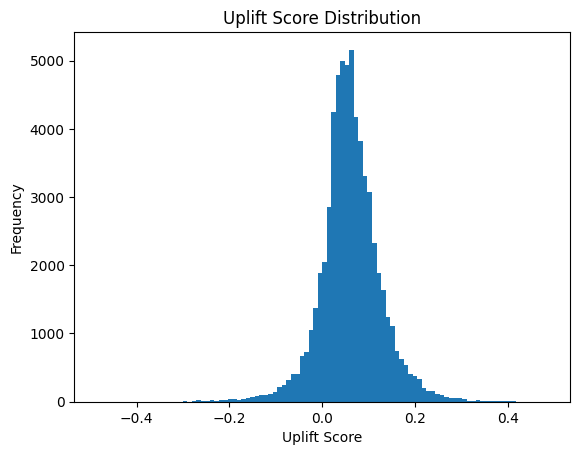

In [ ]:
plt.hist(df_model['score'], bins=100)
plt.xlabel('Uplift Score')
plt.ylabel('Frequency')
plt.title('Uplift Score Distribution')
plt.show()

In [ ]:
#CN:
df['target_class'] = 0
#CR:
df.loc[(df.treatment == 0) & (df.target != 0),'target_class'] = 1
#TN:
df.loc[(df.treatment != 0) & (df.target == 0),'target_class'] = 2
#TR:
df.loc[(df.treatment != 0) & (df.target != 0),'target_class'] = 3

df['target_class'].value_counts()

2    35562
0    19044
3     7132
1     2262
Name: target_class, dtype: int64

In [ ]:
# score 가 0 이상인

score_count = df_model[df_model['score'] >= 0]['score'].count()
total_count = len(df_model)

positive_score_ratio = score_count / total_count
print("Positive Score Ratio:", positive_score_ratio)


Positive Score Ratio: 0.871734375


In [ ]:
# 임계값 설정
threshold = 0

# Pesuadables 그룹으로 간주되는 데이터 개수 계산
pesuadables_count = len(df_model[df_model['score'] >= threshold])

# 전체 데이터 개수
total_count = len(df_model)

# Pesuadables 그룹의 비율 계산
pesuadables_ratio = pesuadables_count / total_count

print("Pesuadables 그룹 비율:", pesuadables_ratio)

Pesuadables 그룹 비율: 0.0143125


###  score를 기준으로 세그먼트를 어떻게 나눠야하지?

>✔️ skewness 는 높지 않지만 약 87% 유저의 score가 0.0 이상을 기록했다.
업리프팅 사분면에 따라 세그먼터를 나눠야하는데, 어떤 기준으로 나눠야할까..?

> score 가 높을 수록 Pesuadables 고객으로 봐야하는것 같은데  그 높다는 기준을 어디로 잡아야 하는지 헷갈린다!

### 🤔결론!
일단 크게 치우쳐지지 않고,
* score 가 0 이상인경우 87%
* 0.1 인경우, 23%
* 0.2 인 경우 2.5%
* 0.3 부터는 0.2 %로 매우 적다.
* scroe가 음수인 경우는 13% 가 있음.

크게 4가지로 분류할 수 는 없을 것 같지만, 확실한건 해당 광고시 부정적인 영향을 끼칠 세그먼트는 확실히 나눌 수 있다는것!

> 일단은 0 =< surething < 0.1  인경우 SureThings \
0.1 이상인경우 Persuadables , 음수인경우 Lost Causes 로 나누었다.



In [ ]:
def segment_customers(score):
    if score >= 0 and score < 0.1:
        return "Sure Things"
    elif score >= 0.1:
        return "Persuadables"
    elif score >= -0.1 and score < 0:
        return "Lost Causes"
    else:
        return "Sleeping dogs"

df_model['segment'] = df_model['score'].apply(segment_customers)
df_model['segment'].value_counts()

Sure Things      41285
Persuadables     14506
Lost Causes       7293
Sleeping dogs      916
Name: segment, dtype: int64

In [ ]:
df_model['segment'].value_counts()

Sure Things      55791
Sleeping Dogs     8209
Name: segment, dtype: int64